In [1]:
import sympy
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import sherpa
%display typeset

# Modelo proposto: SEIAMRQ

In [3]:
def model(t,y,params):
        S, E, I, A, M, R, C = y
        rho, beta, gamma, chi, apha, theta, delta ,mu = params
                
        if 0<t<150:
            chi=0.4
        if t > 200:
            mu=0.8
            chi=0.05
        return [
            -beta*(1-chi)*S*I + mu*R,#  dS/dt
            #chi*S, #dQ/dt Quarentenados acumulados
            beta*(1-chi)*S*I - (theta)*E, #dE/dt
            (1-alpha)*theta*E - gamma*I - rho*I,# dI/dt
            alpha*theta*E - delta*A, #dA/dt
            gamma*I, #dM/dt Mortes acumuladas
            rho*I + delta*A - mu*R,#dR/dt
            (1-alpha)*theta*E # Infectados acumulados
        ]

# Equilíbrio livre de Doença e Cálculo do R0

In [8]:
var('S, E, I, A, M, R, rho, beta, gamma, chi, alpha, theta,delta,mu, N')

(S, E, I, A, M, R, rho, beta, gamma, chi, alpha, theta, delta, mu, N)

In [16]:
# Para nossa análise podemos desacoplar os recuperados e mortos pois não participam da nossa dinâmica

dsdt = -beta*(1-chi)*S*I + mu*R # dS/dt
dedt = beta*(1-chi)*S*I - (theta)*E #dE/dt
didt =  (1-alpha)*theta*E - gamma*I - rho*I #dI/dt
dadt =  alpha*theta*E - delta*A #dA/dt
drdt = rho*I + delta*A - mu*R #dR/dt

In [17]:
#Equilíbrios lívre de doença

solve([dsdt,dedt,didt,dadt,drdt],[S,E,I,A,R])

[[S == r3, E == 0, I == 0, A == 0, R == 0]]

In [18]:
#Matriz Jacobiana

jack = jacobian([dsdt,dedt,didt,dadt,drdt],[S,E,I,A,R])
jack

[  I*beta*(chi - 1)                  0   S*beta*(chi - 1)                  0                 mu]
[ -I*beta*(chi - 1)             -theta  -S*beta*(chi - 1)                  0                  0]
[                 0 -(alpha - 1)*theta       -gamma - rho                  0                  0]
[                 0        alpha*theta                  0             -delta                  0]
[                 0                  0                rho              delta                -mu]

In [19]:
cp = jack.characteristic_polynomial()
cp

x^5 + (-I*beta*chi + I*beta + delta + gamma + mu + rho + theta)*x^4 + (-S*alpha*beta*chi*theta - I*beta*chi*delta - I*beta*chi*gamma - I*beta*chi*mu - I*beta*chi*rho + S*alpha*beta*theta - I*beta*chi*theta + S*beta*chi*theta + I*beta*delta + I*beta*gamma + I*beta*mu + I*beta*rho + I*beta*theta - S*beta*theta + delta*gamma + delta*mu + gamma*mu + delta*rho + mu*rho + delta*theta + gamma*theta + mu*theta + rho*theta)*x^3 + (-S*alpha*beta*chi*delta*theta - S*alpha*beta*chi*mu*theta - I*beta*chi*delta*gamma - I*beta*chi*delta*mu - I*beta*chi*gamma*mu - I*beta*chi*delta*rho - I*beta*chi*mu*rho + S*alpha*beta*delta*theta - I*beta*chi*delta*theta + S*beta*chi*delta*theta - I*beta*chi*gamma*theta + S*alpha*beta*mu*theta - I*beta*chi*mu*theta + S*beta*chi*mu*theta - I*beta*chi*rho*theta + I*beta*delta*gamma + I*beta*delta*mu + I*beta*gamma*mu + I*beta*delta*rho + I*beta*mu*rho + I*beta*delta*theta - S*beta*delta*theta + I*beta*gamma*theta + I*beta*mu*theta - S*beta*mu*theta + I*beta*rho*theta + delta*gamma*mu + delta*mu*rho + delta*gamma*theta + delta*mu*theta + gamma*mu*theta + delta*rho*theta + mu*rho*theta)*x^2 + (I*alpha*beta*chi*delta*mu*theta - S*alpha*beta*chi*delta*mu*theta - I*alpha*beta*chi*mu*rho*theta - I*beta*chi*delta*gamma*mu - I*beta*chi*delta*mu*rho - I*beta*chi*delta*gamma*theta - I*alpha*beta*delta*mu*theta + S*alpha*beta*delta*mu*theta - I*beta*chi*delta*mu*theta + S*beta*chi*delta*mu*theta - I*beta*chi*gamma*mu*theta - I*beta*chi*delta*rho*theta + I*alpha*beta*mu*rho*theta + I*beta*delta*gamma*mu + I*beta*delta*mu*rho + I*beta*delta*gamma*theta + I*beta*delta*mu*theta - S*beta*delta*mu*theta + I*beta*gamma*mu*theta + I*beta*delta*rho*theta + delta*gamma*mu*theta + delta*mu*rho*theta)*x + I*alpha*beta*chi*delta*gamma*mu*theta - I*alpha*beta*delta*gamma*mu*theta - I*beta*chi*delta*gamma*mu*theta + I*beta*delta*gamma*mu*theta

In [20]:
#Cálculo do R_0

In [21]:
F_cal = matrix([[-beta*(1-chi)*S*I + mu*R],[0],[0]])
F_cal

[I*S*beta*(chi - 1) + R*mu]
[                        0]
[                        0]

In [22]:
V_cal_neg = matrix([[theta*E],[rho*I],[delta*A]])
V_cal_neg

[E*theta]
[  I*rho]
[A*delta]

In [23]:
V_cal_pos = matrix([[0],[(1-alpha)*theta*E],[alpha*theta*E]])
V_cal_pos

[                   0]
[-E*(alpha - 1)*theta]
[       E*alpha*theta]

In [24]:
V_cal = V_cal_neg-V_cal_pos
V_cal

[                    E*theta]
[E*(alpha - 1)*theta + I*rho]
[   -E*alpha*theta + A*delta]

In [25]:
F = jacobian(F_cal(S=1),[E,I,A])
F

[             0 beta*(chi - 1)              0]
[             0              0              0]
[             0              0              0]

In [26]:
V = jacobian(V_cal(S=1),[E,I,A])
V

[            theta                 0                 0]
[(alpha - 1)*theta               rho                 0]
[     -alpha*theta                 0             delta]

In [27]:
M = F*V.inverse()
M=M.simplify_full()
M

[-((alpha - 1)*beta*chi - (alpha - 1)*beta)/rho                          (beta*chi - beta)/rho                                              0]
[                                             0                                              0                                              0]
[                                             0                                              0                                              0]

In [28]:
M.eigenvalues()

[-((alpha - 1)*beta*chi - (alpha - 1)*beta)/rho, 0, 0]

In [29]:
R0 = M[0,0].simplify_full()
R0

-((alpha - 1)*beta*chi - (alpha - 1)*beta)/rho

In [30]:
R0.variables()

(alpha, beta, chi, rho)

In [31]:
Ft = jacobian(F_cal,[E,I,A])
Vt = jacobian(V_cal,[E,I,A])
Mt = Ft*Vt.inverse()
show(pretty_print(html('$R_t=$')))
Rt = Mt[0,0]
Rt

<script type="math/tex">R_t=</script>

None

-S*(alpha - 1)*beta*(chi - 1)/rho

# Simulações

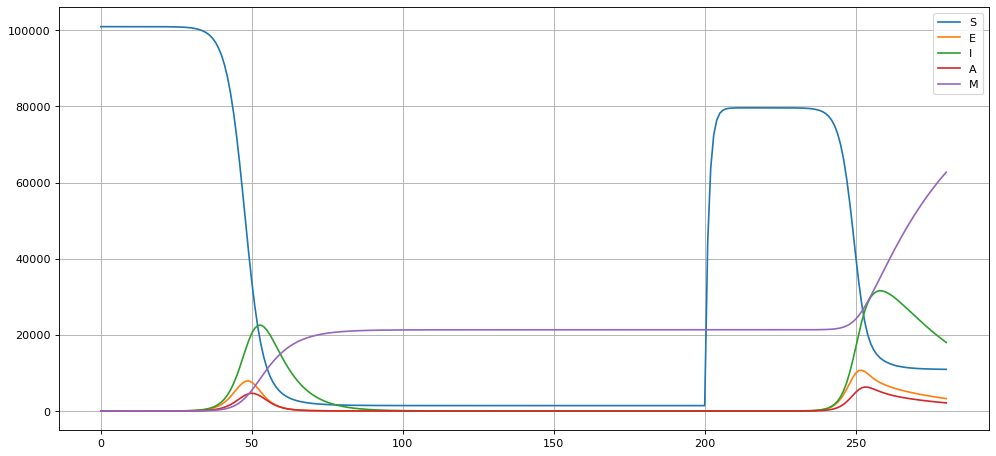

In [32]:
#parametros
rho=0.09
beta =1.70
gamma =0.05
chi =0.66
alpha=0.40
theta=0.99
delta=0.64
mu=0
N=101960

T = ode_solver()
T.function = model
T.algorithm = "rk8pd"
inits = [.99,0,1e-7,0,0,0,0]
tspan = [0,280]
T.ode_solve(tspan, inits, num_points=280, params = [rho, beta, gamma, chi,alpha,theta,delta,mu])

def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

popPT=N
a= get_sim_array(T.solution)*popPT
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(a[:,0],label='S')
plt.plot(a[:,1],label='E')
plt.plot(a[:,2],label='I')
plt.plot(a[:,3],label='A')
plt.plot(a[:,4],label='M')
#plt.plot(a[:,5],label='R')
plt.grid(True)
plt.legend()

# Análise de Sensibilidade

In [33]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from epimodels.continuous import models as cm
import seaborn as sns
import numpy as np
import pandas as pd
import pylab as plt

In [34]:
def model(t,y,params):
        S, E, I, A, M,R = y
        rho, beta, gamma, chi, alpha, theta,delta, mu = params
        
        if t > 120:
            mu=0.8
            chi=0.10
         #   beta =0.95
          #  chi =0.05
        return [
            -beta*(1-chi)*S*I + mu*R,#  dS/dt
            #chi*S, #dQ/dt Quarentenados acumulados
            beta*(1-chi)*S*I - (theta)*E, #dE/dt
            (1-alpha)*theta*E - gamma*I - rho*I,# dI/dt
            alpha*theta*E - delta*A, #dA/dt
            gamma*I, #dM/dt Mortes acumuladas
            rho*I + delta*A - mu*R #dR/dt
        ]

In [35]:
inits = [.99,0,1e-6,0,0,0]
tspan = [0,280]

def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

#parametros
params = {
"rho" : 0.055674023482531365,
"beta" : 0.8239079463815573,
"gamma" : 0.04,
"chi" : 0.5949144727418315,
"alpha" : 0.1889742696595224,
"theta" : 0.08787237945590756,
"delta" : 0.3082254956051211,
"mu" : 0
}
popPT = 10.28e6

In [36]:
#Definindo a análise
problem = {
    'num_vars': 8,
    'names': list(params.keys()),
    'bounds': [[0,.3],[0,1.],[0.01,0.04],[0.2,1],[0.1,0.5],[0.01,1],
              [0.01,1],[0.01,0.03]]
}

#Gerando amostras
param_values = saltelli.sample(problem, 1000)

In [37]:
#Rodando o modelo
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

def eval_model(parametros):
    mod = ode_solver()
    mod.function = model
    mod.algorithm = "rk8pd"
    mod.ode_solve(tspan, inits, num_points=280, params = parametros)
    sim = get_sim_array(mod.solution)
    Is = sim[:,-4]
    Y = max(Is)
    return Y

parms = dict(zip(params.keys(),param_values))
param_values[1]

array([0.15029297, 0.09667969, 0.02555664, 0.74140625, 0.21210938,
       0.9081543 , 0.05543945, 0.02798828])

In [38]:
from multiprocessing import Pool

Po = Pool()
Y = Po.map(eval_model, param_values)

In [39]:
Po.close()

In [40]:
Si = sobol.analyze(problem, np.array(Y), print_to_console=False)

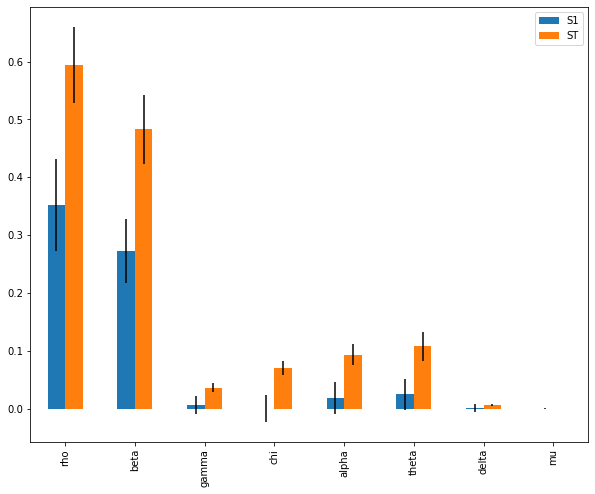

In [42]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    fig, ax = plt.subplots(1, figsize=(10,8))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
plot_sobol(Si,problem)

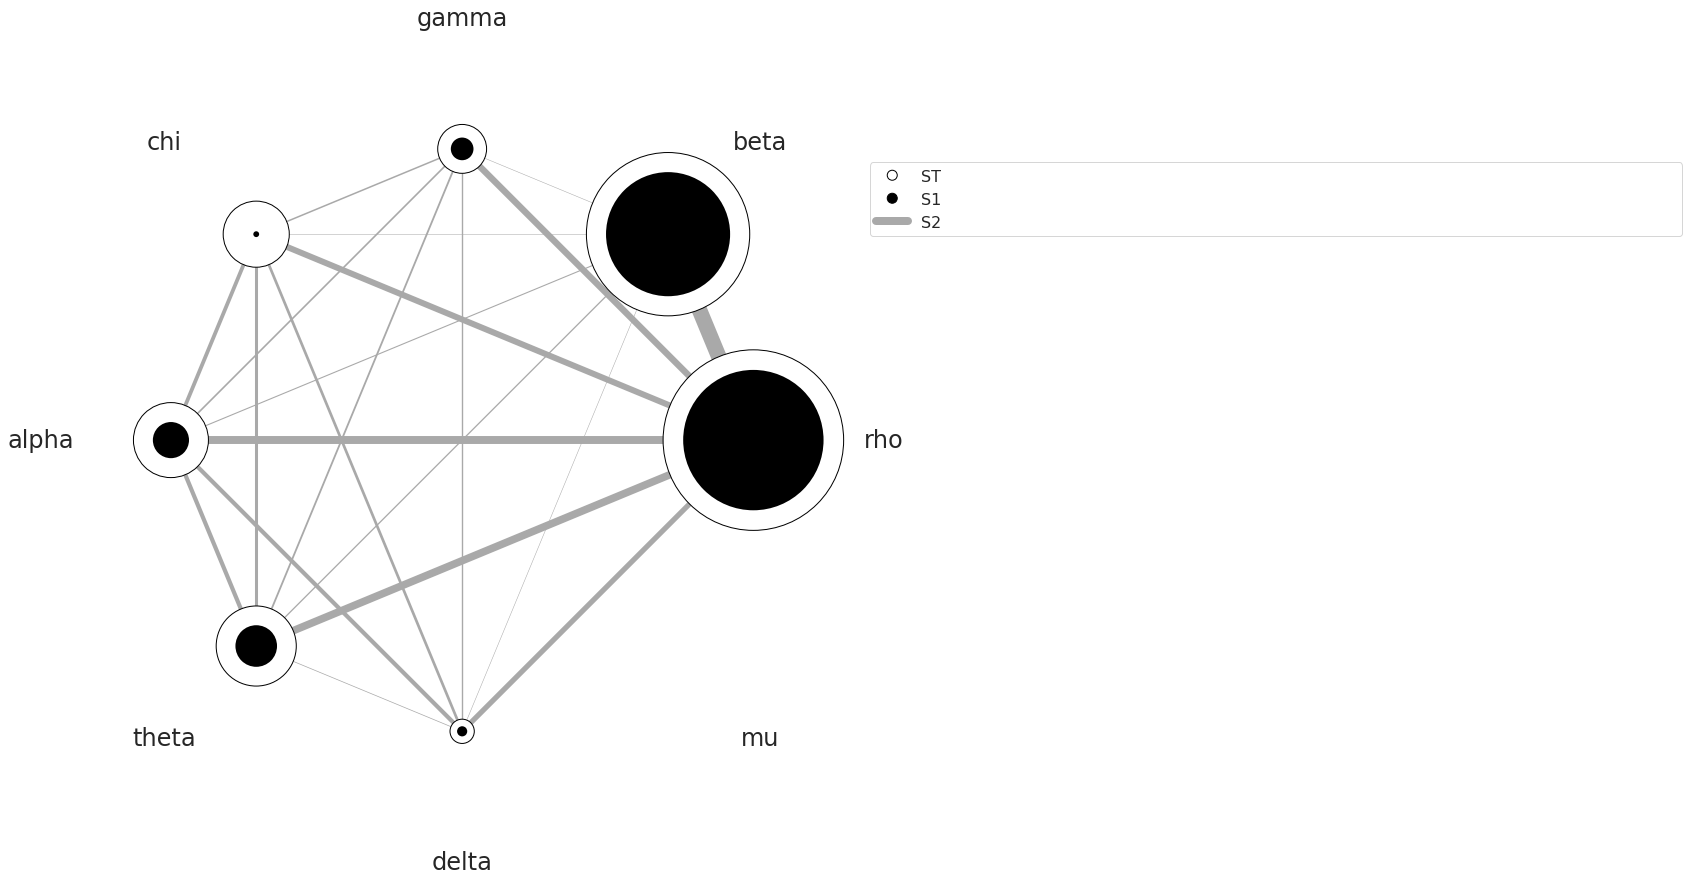

In [43]:
#Uma visualização melhor dos resultados

import itertools
from math import pi
from matplotlib.legend_handler import HandlerPatch


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names, fontsize=24)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig



class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand', fontsize=16,
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)

# Otimização dos parâmetros com os dados

In [45]:
# Obtendo os dados
df = pd.read_csv("owid-covid-data.csv")
only_pt = df["location"] == "Portugal"
df = df[only_pt]
html(df.tail().to_html())

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
41714,PRT,Europe,Portugal,2020-11-13,198011.0,5839.0,5237.286,3181.0,78.0,63.000,19419.112,572.636,513.625,311.963,7.650,6.178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,82.05,0.847
41715,PRT,Europe,Portugal,2020-11-14,204664.0,6653.0,5394.857,3250.0,69.0,65.429,20071.578,652.466,529.078,318.730,6.767,6.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,82.05,0.847
41716,PRT,Europe,Portugal,2020-11-15,211266.0,6602.0,5389.429,3305.0,55.0,65.286,20719.042,647.464,528.546,324.124,5.394,6.403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,82.05,0.847
41717,PRT,Europe,Portugal,2020-11-16,217301.0,6035.0,5425.286,3381.0,76.0,69.286,21310.900,591.858,532.063,331.578,7.453,6.795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,82.05,0.847
41718,PRT,Europe,Portugal,2020-11-17,225672.0,8371.0,6036.000,3472.0,91.0,73.286,22131.851,820.951,591.956,340.502,8.924,7.187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,82.05,0.847


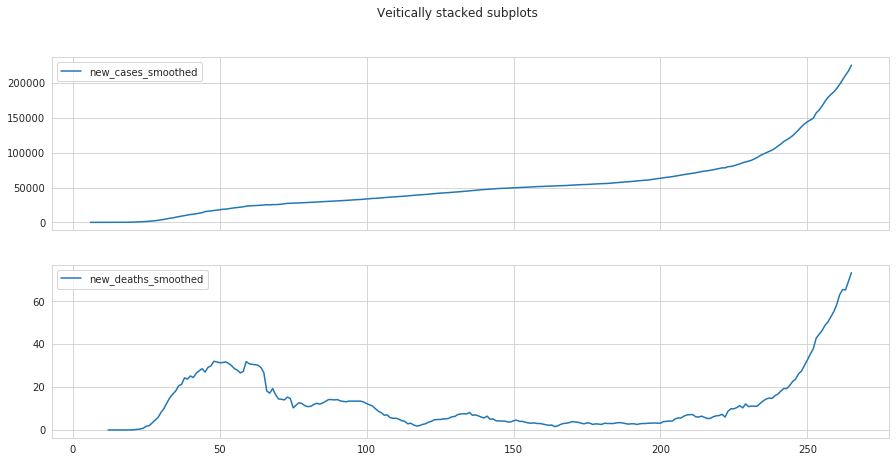

In [46]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(15,7))
fig.suptitle('Veitically stacked subplots')

axs[0].plot(range(len(df)), df['total_cases'],label= "new_cases_smoothed")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(range(len(df)), df['new_deaths_smoothed'],label= "new_deaths_smoothed")
axs[1].grid(True)
axs[1].legend()

In [47]:
import sherpa

In [49]:
def model(t,y,params):
        S, E, I, A, M, R, C = y
        rho, beta, gamma, chi, apha, theta, delta ,mu = params
                
        if 0<t<150:
            chi=0.4
        if t > 200:
            mu=0.8
            chi=0.05
        return [
            -beta*(1-chi)*S*I + mu*R,#  dS/dt
            #chi*S, #dQ/dt Quarentenados acumulados
            beta*(1-chi)*S*I - (theta)*E, #dE/dt
            (1-alpha)*theta*E - gamma*I - rho*I,# dI/dt
            alpha*theta*E - delta*A, #dA/dt
            gamma*I, #dM/dt Mortes acumuladas
            rho*I + delta*A - mu*R,#dR/dt
            (1-alpha)*theta*E # Infectados acumulados
        ]
#parametros
rho=0.09
beta =1.70
gamma =0.05
chi =0.66
alpha=0.40
theta=0.99
delta=0.64
mu=0
N=101960
    
T = ode_solver()
T.function = model
T.algorithm = "rk8pd"
inits = [.99,0,1e-7,0,0,0,0]
tspan = [0,280]
T.ode_solve(tspan, inits, num_points=280, params = [rho, beta, gamma, chi,alpha,theta,delta,mu])

parameters = [
    sherpa.Continuous(name='rho',range=[0.06,0.12]),
    sherpa.Continuous(name='beta',range=[1.3,2]),
    sherpa.Continuous(name='gamma',range=[0.022,0.038]),
    sherpa.Continuous(name='chi',range=[0.45,0.65]),
    sherpa.Continuous(name='alpha',range=[0.35,0.55]),
    sherpa.Continuous(name='theta',range=[0.9,1.5]),
    sherpa.Continuous(name='delta',range=[0.5,0.8]),
    sherpa.Discrete(name='t0',range=[0,25])]
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=1000)

study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

trial = study.get_suggestion()

ld = len(df.total_cases)
popPT=10196
for trial in study:
    pars = [trial.parameters[n] for n in ['rho', 'beta', 'gamma','chi','alpha', 'theta', 'delta']]
    pars.append(0)
    t0 = trial.parameters['t0']
    T.ode_solve(tspan, inits, num_points=290, params=pars)
    sim = get_sim_array(T.solution)
    H = sim[:ld+t0,2]*popPT
    D = sim[:ld+t0,-3]*popPT
    loss = sum((df.new_cases_smoothed-H[t0:t0+ld])**2) +sum((df.total_deaths-D[t0:t0+ld])**2)/2*ld
    study.add_observation(trial=trial,
                          objective=loss)
    study.finalize(trial)

In [50]:
res = study.get_best_result()
res

{'Trial-ID': 318,
 'Iteration': 1,
 'alpha': 0.4163522955260267,
 'beta': 1.4461254031589241,
 'chi': 0.5136565430048639,
 'delta': 0.697139588106418,
 'gamma': 0.028324516622182307,
 'rho': 0.07183040212264202,
 't0': 2,
 'theta': 0.9328143928168823,
 'Objective': 2075884011.5615017}

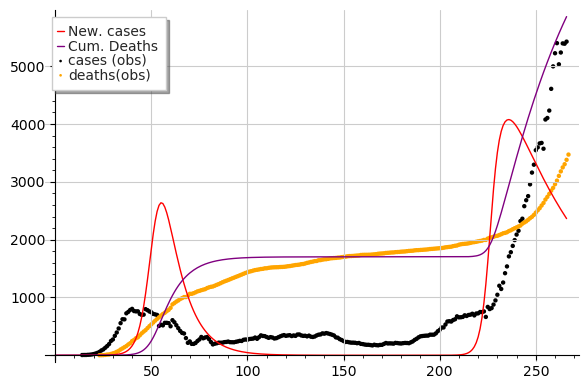

In [51]:
pars=[res['rho'],
       res['beta'],
       res['gamma'],
       res['chi'],
       res['alpha'],
       res['theta'],
       res['delta'],
       0,
       res['t0']]
T.ode_solve(tspan, inits, num_points=ld, params=list(pars[:-1]))
t0=pars[-1]
sim = get_sim_array(T.solution)*popPT
h = list_plot(sim[:ld+t0,2],color='red',legend_label='New. cases', plotjoined=True)
d = list_plot(sim[:ld+t0,-3],color='purple', legend_label='Cum. Deaths', plotjoined=True)
cc = list_plot(list(zip(range(t0,ld+t0),df.new_cases_smoothed)), color='black',legend_label='cases (obs)')
cd = list_plot(list(zip(range(t0,ld+t0),df.total_deaths)), color='orange',legend_label='deaths(obs)')
show(h+d+cc+cd)

In [52]:
T = ode_solver()
T.function = model
T.algorithm = "rk8pd"
inits = [.99,0,1e-7,0,0,0,0]
tspan = [0,280]
T.ode_solve(tspan, inits, num_points=280, params = [res["rho"], res["beta"], res["gamma"], res["chi"],res["alpha"],res["theta"],res["delta"],0])

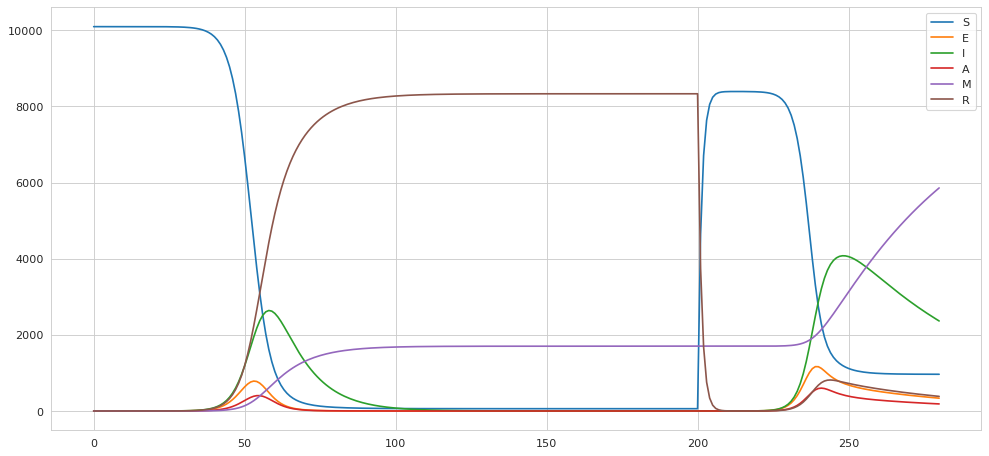

In [54]:
#polt do modelo com os parâmetros otimizados

a = get_sim_array(T.solution)*popPT
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(a[:,0],label='S')
plt.plot(a[:,1],label='E')
plt.plot(a[:,2],label='I')
plt.plot(a[:,3],label='A')
plt.plot(a[:,4],label='M')
plt.plot(a[:,5],label='R')
#plt.plot(a[:,6],label='C')
plt.grid(True)
plt.legend()